In [275]:
# import git
# from os import listdir
# from os.path import isfile, join, dirname, realpath

# def get_git_root(path):
#     """Get git root path
#     """
#     git_repo = git.Repo(path, search_parent_directories=True)
#     git_root = git_repo.git.rev_parse("--show-toplevel")
#     return git_root

# file_path = dirname(realpath(__file__))
# git_path = get_git_root(file_path)
# print(git_path)

In [1]:
import sys
sys.path.append('../../shared')
from inject_tools import *

from pathlib import Path
from os.path import isfile, join
from tqdm import tqdm
from scipy import signal as scisig
from pycbc.detector import Detector

import h5py
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from pathlib import Path
# import joblib

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
detector = 'H'
fw = 4*4096
Tc = 64
gps = event_gps('GW150914') - 100
t_inj = gps # - 0.7
ra = 2.577
dec = 0.575

In [3]:
d = Detector(detector + '1')
pol = 0
fp, fc = d.antenna_pattern(ra, dec, pol, t_inj)

In [4]:
segment = ((gps) - Tc / 2, (gps) + Tc / 2)
hdata = TimeSeries.fetch_open_data(detector + '1', *segment, sample_rate=fw, verbose=True, cache=True)
times = hdata.times.value

Fetched 1 URLs from www.gw-openscience.org for [1126259330 .. 1126259395))
Reading data... [Done]


/anaconda2/envs/gw_env/lib/python3.7/site-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


In [52]:
ccsn_paper = 'abdikamalov'
# ccsn_paper = 'andersen'
# ccsn_paper = 'radice'
data_path = Path('/Users/tommarianer/LOSC Data/ccsn/' + ccsn_paper)
files = [f for f in sorted(listdir(data_path)) if isfile(join(data_path, f))]
print(len(files))

92


In [53]:
file = files[-1]
data = [i.strip().split() for i in open(join(data_path, file)).readlines()]

In [55]:
print(file)
fname = 'injected-' + ccsn_paper + '-' + '.'.join(file.split('.')[2:]) + '-D-' + str(D_kpc) + '.hdf5'
# fname = 'injected-' + ccsn_paper + '-' + file.split('.')[0] + '-D-' + str(D_kpc) + '.hdf5'
# fname = file.split('.')[0]
print(fname)

a_t.dat.A5O05.5
injected-abdikamalov-A5O05.5-D-0.2.hdf5


In [36]:
D_kpc = 0.2 #10
D = D_kpc * 3.086e+21 # cm

if ccsn_paper == 'radice':
    line_s = 1
else:
    line_s = 0

sim_times = np.asarray([float(dat[0]) for dat in data[line_s:]])
hp = np.asarray([float(dat[1]) for dat in data[line_s:]]) / D

if ccsn_paper == 'abdikamalov':
    hc = np.zeros(hp.shape)
else:
    hc = np.asarray([float(dat[2]) for dat in data[line_s:]]) / D

# hc = np.zeros(hp.shape)

dt = sim_times[1] - sim_times[0]
h_rss = np.sqrt(np.dot(hp, hp) * dt + np.dot(hc, hc) * dt)
# h_rss = np.sqrt(hp.dot(hp) * hp.dt).value
print(h_rss, h_rss / 1e-22)

1.6550486211673027e-21 16.550486211673025


In [37]:
h = fp * hp + fc * hc
h = TimeSeries(h, t0=sim_times[0], dt=dt)

h = h.resample(rate=fw, ftype = 'iir', n=20) # downsample to working frequency fw
h = h.highpass(frequency=11, filtfilt=True) # filter out frequencies below 20Hz
window = scisig.tukey(M=len(h), alpha=0.08, sym=True)
h = h * window
h = h.pad(int((fw * Tc - len(h)) / 2))

In [38]:
shift = int((t_inj - (times[0] + Tc/2)) * fw)
print(shift)

h = np.roll(h.value, shift)

h = TimeSeries(h, t0=times[0], dt=hdata.dt)
try:
    h = h.taper()
except:
    print('Warning: no taper')

0


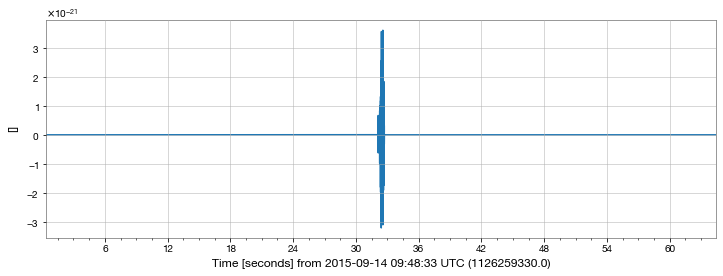

In [39]:
# h_rss = np.sqrt(h.dot(h) * h.dt).value
# print(h_rss, h_rss / 1e-22)

h.plot()
plt.show()

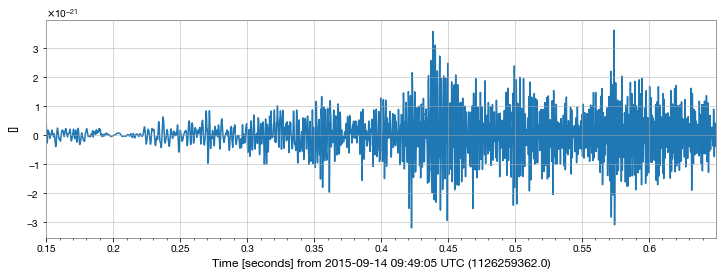

In [40]:
t_snr = 0.25
plot = h.crop(t_inj - t_snr, gps + t_snr).plot()
# plot = h.crop(gps - t_snr, gps + t_snr).plot()
plt.show()

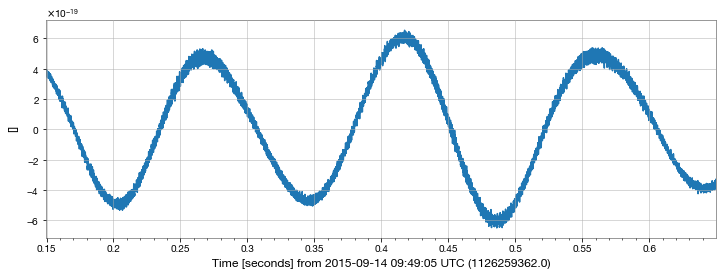

In [41]:
waveform_data = hdata.inject(h)
plot = waveform_data.crop(t_inj - t_snr, t_inj + t_snr).plot()
plt.show()

In [42]:
qt = waveform_data.q_transform(frange=(10, 2048), qrange=(4, 64), whiten=True, tres=0.002)

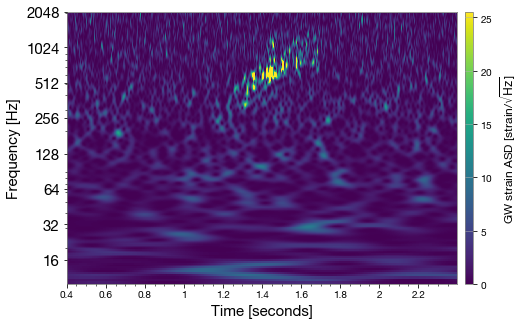

In [43]:
size = (7, 5)
plot = qt.crop(gps - 1, gps + 1).plot(figsize=size, vmin=0, vmax=25.5)
ax = plot.gca()
ax.set_ylim(10, 2048)
ax.set_yscale('log')
ax.colorbar(label='GW strain ASD [strain/$\sqrt{\mathrm{Hz}}$]')
ax.grid(False)
plt.xlabel('Time [seconds]', size=15)
plt.ylabel('Frequency [Hz]', size=15)
ytick_list = [16, 32, 64, 128, 256, 512, 1024, 2048]
ax.set_yticks(ytick_list)
ax.set_yticklabels([str(tick) for tick in ytick_list], size=15)
plot.show()

In [245]:
ra_range = (0, 2*np.pi)
dec_range = (-np.pi/2, np.pi/2)

num_points = 500
grid_ra = np.linspace(ra_range[0], ra_range[1], num_points)
grid_dec = np.linspace(dec_range[0], dec_range[1], num_points)
RA, DEC = np.meshgrid(grid_ra, grid_dec)
RA_vec = RA.flatten()
DEC_vec = DEC.flatten()

In [268]:
h_det = Detector('H1')
l_det = Detector('L1')
score = []
pol = 0
t_inj = 1136359941.689090 #gps + 1439702
for ra, dec in zip(RA_vec, DEC_vec):
    hfp, hfc = h_det.antenna_pattern(ra, dec, pol, t_inj)
    lfp, lfc = l_det.antenna_pattern(ra, dec, pol, t_inj)
    score.append(hfp ** 2 + hfc ** 2 + lfp ** 2 + lfc ** 2)

idx = np.argmax(score)
print(RA_vec[idx], DEC_vec[idx])

5.200311687104547 -0.6893875662687021


In [269]:
idx_gps = 179551
print(idx)
print(score[idx], score[idx_gps])

70413
1.8892584394776746 0.5740616271620118


In [270]:
ra = np.random.uniform(0, 2*np.pi, 1000)
sin_dec = np.random.uniform(-1, 1, 1000)
dec = np.arcsin(sin_dec)

In [273]:
sky_loc = pd.DataFrame({'ra': ra, 'dec': dec})
# display(sky_loc)

In [274]:
params_path = Path('../../shared/injection_params')
sky_loc.to_csv(join(params_path, 'sky_loc_csv.csv'))

In [91]:
# data_path = Path('/Users/tommarianer/LOSC Data/ccsn')
# f = h5py.File(join(data_path, 'GWdatabase.h5'), 'r')
# print(f.keys())

In [92]:
# wf = list(f['waveforms'].keys())
# print(np.asarray(f['waveforms'][wf[0]]))
# h = np.asarray(f['waveforms'][wf[0]]['strain*dist(cm)'])
# times = np.asarray(f['waveforms'][wf[0]]['t-tb(s)'])

In [93]:
# print(h.shape)
# plt.plot(times, h)
# plt.show()